In [250]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets
import numpy as np


In [251]:
Z_DIM = 30

In [252]:
(x_train,y_train),(x_test,y_test) = datasets.mnist.load_data()

In [253]:
print(f"x_train:{x_train.shape} y_train{y_train.shape}")
print(f"x_test:{x_test.shape} y_test{y_test.shape}")

x_train:(60000, 28, 28) y_train(60000,)
x_test:(10000, 28, 28) y_test(10000,)


In [254]:
def process(imgs):
    imgs = imgs.astype("float64")/255
    imgs = np.pad(imgs,((0,0),(2,2),(2,2)),constant_values=0.0)
    imgs = np.expand_dims(imgs,-1)
    return imgs

In [255]:
x_train = process(x_train)
x_test = process(x_test)

In [256]:
print(f"x_train:{x_train.shape} y_train{y_train.shape}")
print(f"x_test:{x_test.shape} y_test{y_test.shape}")

x_train:(60000, 32, 32, 1) y_train(60000,)
x_test:(10000, 32, 32, 1) y_test(10000,)


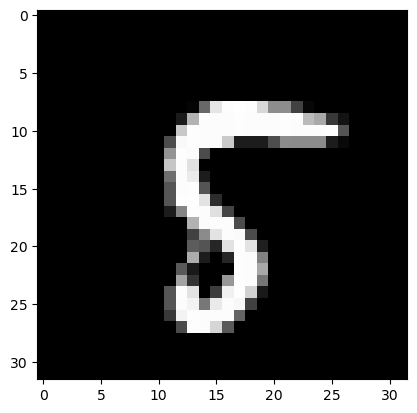

In [257]:
idx = np.random.choice(len(x_train))
plt.imshow(x_train[idx],cmap="gray")

In [258]:
from tensorflow.keras import layers,models
import tensorflow.keras.backend as K

# Encoder

In [259]:
input_encoder = layers.Input(shape=(32,32,1),name="input_encoder")

x = layers.Conv2D(32,kernel_size=(3,3),strides=2,padding="same")(input_encoder)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(64,kernel_size=(3,3),strides=2,padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(128,kernel_size=(3,3),strides=2,padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

shape_before_flatten = K.int_shape(x)[1:]
x = layers.Flatten()(x)
output_encoder = layers.Dense(Z_DIM)(x)

encoder = models.Model(input_encoder,output_encoder)
encoder.summary()



Model: "model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_encoder (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_48 (Conv2D)          (None, 16, 16, 32)        320       
                                                                 
 batch_normalization_78 (Ba  (None, 16, 16, 32)        128       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_78 (LeakyReLU)  (None, 16, 16, 32)        0         
                                                                 
 conv2d_49 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 batch_normalization_79 (Ba  (None, 8, 8, 64)          256       
 tchNormalization)                                        

# Decoder

In [260]:
input_decoder = layers.Input(shape=(Z_DIM,), name="decoder_input")

x = layers.Dense(np.prod(shape_before_flatten))(input_decoder)
x = layers.Reshape(shape_before_flatten)(x)

x = layers.Conv2DTranspose(128,kernel_size=(3,3),padding="same",strides=2)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(64,kernel_size=(3,3),padding="same",strides=2)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(32,kernel_size=(3,3),padding="same",strides=2)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

output_decoder = layers.Conv2D(1,kernel_size=(3,3),strides=1,padding="same",activation="sigmoid",name="output_decoder")(x)

decoder = models.Model(input_decoder,output_decoder)
decoder.summary()

Model: "model_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 30)]              0         
                                                                 
 dense_32 (Dense)            (None, 2048)              63488     
                                                                 
 reshape_10 (Reshape)        (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose_30 (Conv2  (None, 8, 8, 128)         147584    
 DTranspose)                                                     
                                                                 
 batch_normalization_81 (Ba  (None, 8, 8, 128)         512       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_81 (LeakyReLU)  (None, 8, 8, 128)         0  

In [261]:
autoencoder = models.Model(input_encoder, decoder(encoder(input_encoder)))

In [262]:
autoencoder.compile(optimizer="adam",loss="binary_crossentropy")

In [263]:
hist = autoencoder.fit(x_test,x_test,epochs=5,validation_data=(x_test,x_test),shuffle=True)

Epoch 1/5
313/313 [==============================] - 14s 44ms/step - loss: 0.1021 - val_loss: 0.1322
Epoch 2/5
313/313 [==============================] - 13s 41ms/step - loss: 0.0663 - val_loss: 0.0634
Epoch 3/5
313/313 [==============================] - 13s 41ms/step - loss: 0.0627 - val_loss: 0.0676
Epoch 4/5
313/313 [==============================] - 12s 38ms/step - loss: 0.0616 - val_loss: 0.0609
Epoch 5/5
313/313 [==============================] - 11s 36ms/step - loss: 0.0605 - val_loss: 0.0602


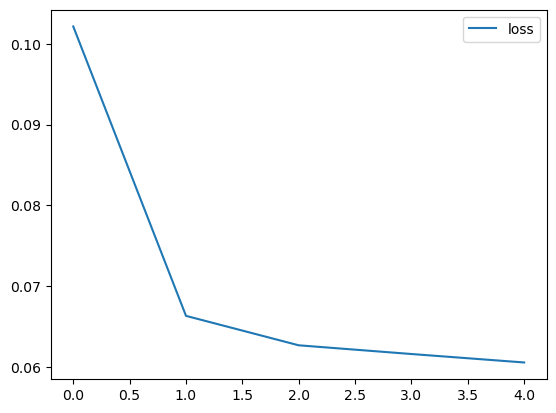

In [264]:
plt.plot(hist.history["loss"],label="loss")
plt.legend()
plt.show()


In [265]:
encode_test = encoder(x_test)
print(encode_test.shape)

(10000, 30)


In [266]:
decode_test = decoder(encode_test)
print(decode_test.shape)

(10000, 32, 32, 1)


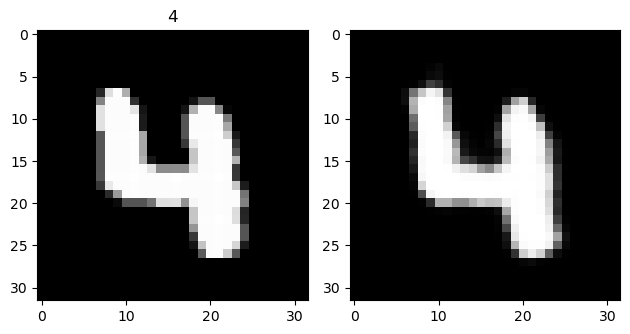

In [267]:

idx = np.random.choice(len(x_test))

fig,axs = plt.subplots(1,2)
axs[0].imshow(x_test[idx],cmap="gray")
axs[0].set_title(y_test[idx])

axs[1].imshow(decode_test[idx],cmap="gray")
#axs[1].set_title(encode_test[idx])
plt.tight_layout()
plt.show()

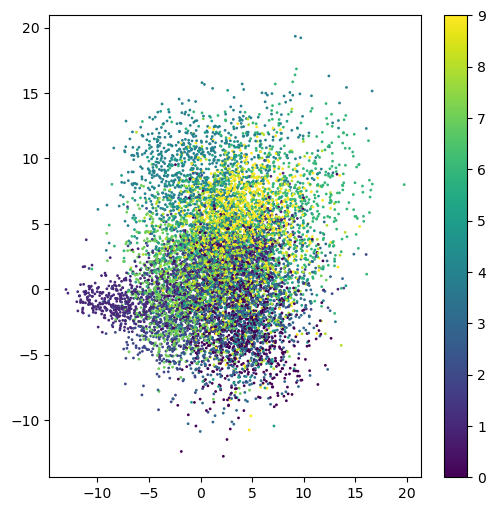

In [268]:
plt.figure(figsize=(6,6))
plt.scatter(encode_test[:,0],encode_test[:,1],c=y_test,s=1)
plt.colorbar()
plt.show()